# Sample script of clustering analysis applied to a relocated seismicity catalog from Southern California see:
Hauksson, Egill, Wenzheng Yang, and Peter M. Shearer. "Waveform relocated earthquake catalog for southern California (1981 to June 2011)." Bulletin of the Seismological Society of America 102.5 (2012): 2239-2244.

    and
    
Zaliapin, Ilya, and Yehuda Ben‐Zion. "Earthquake clusters in southern California I: Identification and stability." Journal of Geophysical Research: Solid Earth 118.6 (2013): 2847-2864.

    and
    
    Goebel, T.H.W., Rosson, Z., Brodsky, E.E., and Walter, J.I., 2019, Aftershock deficiency of induced earthquake sequences during rapid mitigation efforts in Oklahoma: Earth and Planetary Science Letters, v. 522, p. 135–143, doi: 10.1016/j.epsl.2019.06.036.


### the following code performs three primary steps:
    1. calculated nearest-neighbor distance between all events in the catalog
    2. separate the seismicity catalog into families and indpendent background events based on nearest-neighbor threshold
    3. Count the number of aftershocks for each family and plot number of aftershocks over mainshock magnitude

### 0: seismicity map
Load Southern California seismicity catalog and plot with Basemap. 
(this step can be skipped if the mpl Basemap module is not installed)

In [1]:
#specify data file, time and magnitude range
dir_in = 'data'
# this file is generated with: 1_create_mat_eqCat_file.py
file_in = 'NEIC_Chile.mat'
# completeness magntiude = Mmin, and Mmax (which does not need to be specified)
Mmin, Mmax = 3, None
tmin, tmax = 1980, 2025

In [2]:
#------------------------------------------------------------------------------
import matplotlib.pyplot as plt
import numpy as np
import os

#------------------------------my modules-------------------------------------- 
# EqCat is a Python object that is used for catlog processing
from src.EqCat import EqCat
eqCat = EqCat( )
#for methods check source code or uncomment the following line 
print( 'EqCat Methods: ', eqCat.methods)
#=================================2==============================================
#                            load data, select events
#================================================================================
eqCat.loadMatBin(f"{dir_in}/{file_in}")
print('total no. of events', eqCat.size())
eqCat.selectEvents(Mmin, Mmax, 'Mag')
eqCat.selectEvents(tmin, tmax, 'Time')
print('no. of events after Mag/Time selection', eqCat.size())

EqCat Methods:  ['check_keys', 'copy', 'loadEqCat', 'loadMatBin', 'randomize_cat', 'saveMatBin', 'selDicAll', 'selEventsFromID', 'selectEvents', 'size', 'sortCatalog', 'toCart_coordinates', 'todict']
total no. of events 1915
no. of events after Mag/Time selection 1914


the following cell will only run if you have Basemap

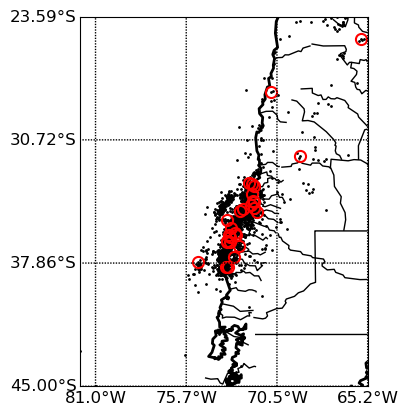

In [3]:
try:
    #os.environ["PROJ_LIB"] = f"{os.environ['HOME']}/opt/anaconda3/share/proj"
    from mpl_toolkits.basemap import Basemap
    b_map = True
except:
    b_map = False
#=================================3==============================================
#                          test plot with Basemap
#================================================================================
projection = 'cyl'
xmin,xmax = eqCat.data['Lon'].min(), eqCat.data['Lon'].max()
ymin,ymax = eqCat.data['Lat'].min(), eqCat.data['Lat'].max()
if b_map:
    # setup equi distance basemap.
    m = Basemap( llcrnrlat  =  ymin,urcrnrlat  =  ymax,
                 llcrnrlon  =  xmin,urcrnrlon  =  xmax,
                 projection = projection,lat_0=(ymin+ymax)*.5,lon_0=(xmin+xmax)*.5,
                 resolution = 'l')
    m.drawstates( linewidth = 1)
    m.drawcoastlines( linewidth= 2)
    a_x, a_y = m( eqCat.data['Lon'], eqCat.data['Lat'])
    m.plot( a_x, a_y, 'ko', ms = 1)
    sel6 = eqCat.data['Mag'] >= 6
    m.plot( a_x[sel6], a_y[sel6], 'ro', ms = 8, mew= 1.5, mfc = 'none')

    m.drawmeridians( np.linspace( int(xmin), xmax, 4),labels=[False,False,False,True],
                     fontsize = 12, fmt = '%.1f')
    m.drawparallels( np.linspace( int(ymin), ymax, 4),labels=[True,False,False,False],
                     fontsize = 12, fmt = '%.2f')

    plt.savefig( file_in.replace( 'mat', 'png'))


### 1: Compute Nearest Neighbor Distances

In [4]:
print(eqCat.data.keys())

dict_keys(['YR', 'MO', 'DY', 'HR', 'MN', 'SC', 'ID', 'Lat', 'Lon', 'Depth', 'Mag', 'Time'])


In [5]:
# Замена ключа ID на ключ N.

data = eqCat.data

new_data = {('N' if key == 'ID' else key): value for key, value in data.items()}

eqCat.data = new_data

print(eqCat.data.keys())

dict_keys(['YR', 'MO', 'DY', 'HR', 'MN', 'SC', 'N', 'Lat', 'Lon', 'Depth', 'Mag', 'Time'])


convert to cartesian using equi-distant projection
depth range:  1.0 251.8
3 %i events with NND=0 
save file data/NEIC_Chile_NND_Mc_3.0.mat
could not find eta_0 file data/NEIC_Chile.mat_Mc_3.0_eta_0.txt use value:  -5


(-13.0, 0.0)

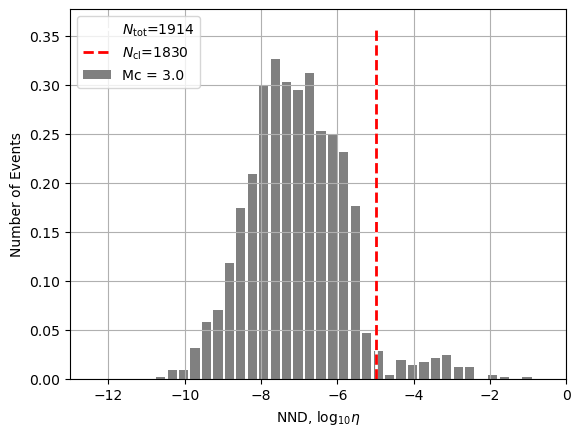

In [6]:
import src.clustering as clustering
# set parameters:fractal dimension and b-value
dPar  = {   # fractal dimension and b for eq. (1) in Zaliapin & Ben-Zion
            'D'           : 1.6, # TODO: - these values should be contrained independently
            'b'           : 1.0, # use: https://github.com/tgoebel/magnitude-distribution for b-value
            'Mc'          : Mmin,
            #=================plotting==============
             # these parameters rarely have to be changes
            'eta_binsize' :  .3,
            'xmin' : -13, 'xmax' : 0,
          }


#================================================================================
#                           to cartesian coordinates
#================================================================================
# two ways to do the distance comp: 1 project into equal distance azimuthal , comp Cartersian distance in 3D
#                                   2 get surface distance from lon, lat (haversine), use pythagoras to include depth
if b_map:
    eqCat.toCart_coordinates( projection = 'eqdc')
    print( 'convert to cartesian using equi-distant projection')
#==================================2=============================================
#                       compute space-time-magnitude distance, histogram
#================================================================================
eqCat.data['Z'] = eqCat.data['Depth']
print('depth range: ', eqCat.data['Z'].min(), eqCat.data['Z'].max())
dNND = clustering.NND_eta( eqCat, dPar,  
                              correct_co_located = True, verbose= True)
###histogram
aBins        = np.arange( -13, 1, dPar['eta_binsize'], dtype = float)
aHist, aBins = np.histogram( np.log10( dNND['aNND'][dNND['aNND']>0]), aBins)
aBins = aBins[0:-1] + dPar['eta_binsize']*.5
# correct for binsize
aHist = aHist/dPar['eta_binsize']
# to pdf (prob. density)
aHist /= eqCat.size()
#=================================3==============================================
#                            save results
#================================================================================
import scipy.io
NND_file = 'data/%s_NND_Mc_%.1f.mat'%( file_in.split('.')[0], dPar['Mc'])
print( 'save file', NND_file)
scipy.io.savemat( NND_file, dNND, do_compression  = True)

#=================================4==============================================
#                          plot histogram
#================================================================================
# load eta_0 value - only for plotting purposes
eta_0_file = '%s/%s_Mc_%.1f_eta_0.txt'%(dir_in, file_in, dPar['Mc'])
if os.path.isfile( eta_0_file):
    print( 'load eta_0 from file'),
    f_eta_0 = np.loadtxt( eta_0_file, dtype = float)
    print( 'eta_0',f_eta_0)
else:
    f_eta_0 = -5
    print( 'could not find eta_0 file', eta_0_file, 'use value: ', f_eta_0)

fig, ax = plt.subplots()
#ax.plot( vBin, vHist, 'ko')
ax.bar( aBins, aHist, width =.8*dPar['eta_binsize'], align = 'edge', color = '.5', label = 'Mc = %.1f'%( dPar['Mc']))
ax.plot( [f_eta_0, f_eta_0], ax.get_ylim(), 'w-',  lw = 2, label = '$N_\mathrm{tot}$=%i'%( eqCat.size()))
ax.plot( [f_eta_0, f_eta_0], ax.get_ylim(), 'r--', lw = 2, label = '$N_\mathrm{cl}$=%i'%( dNND['aNND'][dNND['aNND']<1e-5].shape[0]))

ax.legend( loc = 'upper left')
ax.set_xlabel( 'NND, log$_{10} \eta$')
ax.set_ylabel( 'Number of Events')
ax.grid( 'on')
ax.set_xlim( dPar['xmin'], dPar['xmax'])

The above figure shows a histogram of nearest parent space-time-magnitude distance in the catalog. 
Note that two distinct modes arise from a typical earthquake catalog: a clustered mode (left) 
and a background mode (right). The former represent omori-type clustering (typically 'nearer') while the latter represents the background poisson process. Earthquakes in the background mode are earthquakes that, observably, are not triggered from a previous earthquake. $\eta_0$ is the cutoff between these two modes. Practically, this will result in all connections between earethquakes exceeding this cutoff will be removed, thus forming distinct clusters of earthquakes.

For a quick analysis, it is possible to simply pick a value that separates these modes. Smaller values will lead to smaller clusters, larger values will lead to more generous clusters but may include background seismicity.

### 2: separate clusters from independent background and compile event families

In [7]:
dPar['eta_0'] = f_eta_0
print( 'similarity threshold', dPar['eta_0'])

similarity threshold -5


In [8]:
clust_file = file_in.replace( 'all.mat', 'Mc_%.1f_clusters.mat'%( dPar['Mc']))
    
dNND['aNND'] = np.log10( dNND['aNND'])
# clustering according to eta_0 similarity criteria
dClust = clustering.compileClust( dNND, f_eta_0, useLargerEvents = False)
#=================================4==========================================================================
#                           save results
#============================================================================================================
scipy.io.savemat( os.path.join( dir_in,clust_file), dClust, do_compression=True)


assuming threshold (-5) is a MAXIMUM, select similarity values BELOW this threshold
---------compileClust - initial numbers:------
No. singles: 82
No. triggered: 1830, 1830,No. tot. 1830 1911
N event IDs in more than one cluster: 0
initial singles now parents - remove from dClust['0']:  8
---------------final result--------------------------
 Ntot in cluster: 1838, N-parent(=N-clust): 8,No. singles: 74, Ntot. offspring (includes doubles):  1830
trig. fraction:  0.96 frac.MS:  0.0 single:  0.04
Ntot in cat. 1912 N-trig + N-ind 1912


### let's create a couple of test plots to check whether everythin is working
the first plot provides a rough overview of clustered and independent events in a rescale space-time domain

This provides a visualization of the clustering behavior outlined above. This time in normalized space distance ($R_{ij}$) versus normalized time distance ($T_{ij}$). Where:

$$ R_{ij} = r_{ij}^d\times10^{bM_i/2} $$
$$ T_{ij} = t_{ij}\times10^{bM_i/2} $$

size of offspring catalog 1911 size of parent cat 1911
check if integral ~1 0.962


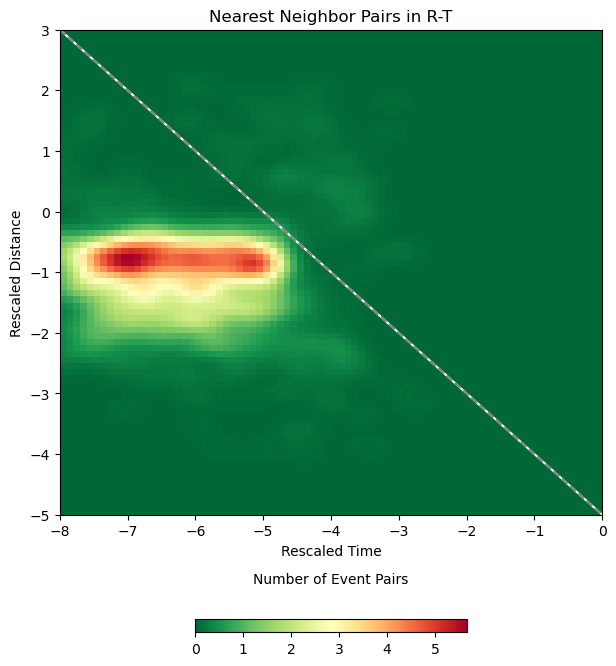

In [9]:
#=======event-pair density in r-T============================
catChild=  EqCat()
catParent= EqCat()
catChild.copy(  eqCat)
catParent.copy( eqCat)
catChild.selEventsFromID(    dNND['aEqID_c'], repeats = True)
catParent.selEventsFromID(   dNND['aEqID_p'], repeats = True)
print( 'size of offspring catalog', catChild.size(), 'size of parent cat', catParent.size())  

#compute re-scaled interevent times and distances
a_R, a_T = clustering.rescaled_t_r(catChild, catParent, dPar)
# plot event pair density 
fig = clustering.plot_R_T( a_T, a_R, f_eta_0)

as you can see there are two different statistical modes 
(sort of like peaks in a histogram except for now you are looking at a 2D histogram)
Which mode (red area) correponds to the background events and which mode marks the aftershocks?

Now let's also look at the different families and how individual events are linked

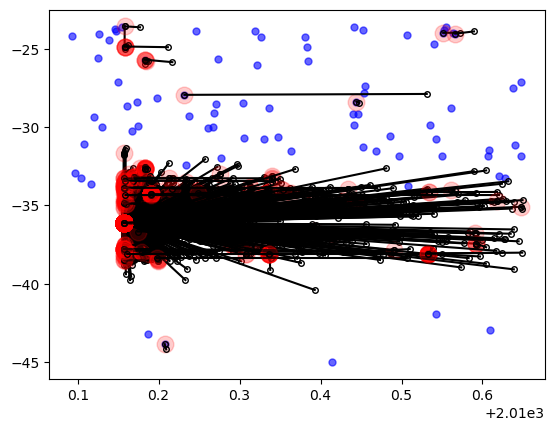

In [10]:
#==================================4=============================================
#                          spanning tree
#================================================================================
plt.figure( 1)
ax = plt.subplot(111)  
for iEv in range( catParent.size()):
    print( f"MS-ID, {int(catParent.data['N'][iEv]):d}, t-Par: {catParent.data['Time'][iEv]:.5f},'t-child', {eqCat.data['Time'][iEv]:.5f}", end= "\r")

    if dNND['aNND'][iEv] < dPar['eta_0']:#triggered cluster
        ax.plot( [catParent.data['Time'][iEv]], [catParent.data['Lat'][iEv]], 'ro', ms = 12, alpha = .2)
        ax.plot( [catParent.data['Time'][iEv],catChild.data['Time'][iEv]],
                  [catParent.data['Lat'][iEv], catChild.data['Lat'][iEv]], 'k-', marker = 'o', ms = 4, mew =1, mfc = 'none')
    else: # independent events
        ax.plot( [catChild.data['Time'][iEv]], [catChild.data['Lat'][iEv]], 'bo', ms = 5, alpha = .6)

    


The blue dots in the above plot are independent background events. That means their nearest neighbor
is beyond the chosen (or calculated) eta_0 value.
The red and black circles are clustered events linked by thin black lines.
The darker the red color the more events are linked to that particular parent.
Black circles are the last generation in a trigger series, i.e., aftershocks that do not produce aftershocks
themselves.
Can you dedetect some major triggering events? (Hint: think about major eqs. in 1992, 1999, 2010)

### 3: count aftershocks and plot productivity relation

In [11]:
eqCat.data

{'YR': array([2010., 2010., 2010., ..., 2010., 2010., 2010.]),
 'MO': array([2., 2., 2., ..., 8., 8., 8.]),
 'DY': array([ 3.,  3.,  3., ..., 25., 25., 26.]),
 'HR': array([ 7., 16., 18., ..., 22., 23.,  1.]),
 'MN': array([26., 20., 30., ..., 34., 40., 52.]),
 'SC': array([36.8, 30.3, 34.4, ..., 56. , 22. , 12. ]),
 'N': array([1914, 1913, 1912, ...,    2,    1,    0]),
 'Lat': array([-31.619, -24.059, -24.213, ..., -38.011, -35.219, -34.666]),
 'Lon': array([-66.352, -67.6  , -67.178, ..., -73.082, -72.171, -73.189]),
 'Depth': array([128.5, 220. , 217.1, ...,  15. ,   8.8,  34.6]),
 'Mag': array([4.7, 4. , 4.6, ..., 4.6, 4.2, 4. ]),
 'Time': array([2010.09126065, 2010.09227641, 2010.09252388, ..., 2010.64915319,
        2010.64927768, 2010.64952851]),
 'X': array([1352.35939903, 1283.6875642 , 1326.0198618 , ...,  711.54631367,
         795.81917404,  703.56907792]),
 'Y': array([1491.01108645, 2337.86577958, 2318.13117768, ...,  804.46268831,
        1114.14192503, 1176.44758281]),

In [12]:

#=================================1==============================================
#                            load data, select events
#================================================================================
N_tot = eqCat.size()
print(  'total no. of events', N_tot)
#=================================2==========================================================================
#                     singles are counted as MS with 0 AS
#============================================================================================================
print( 'total number of clusters', len(  dClust.keys()), 'no. of BG events', dClust['0'].shape[0])
a_ID_single  = dClust['0']

# IDs of BG events
a_iSel       = np.zeros( eqCat.size(), dtype = int)
a_mag_single = np.zeros( len( a_ID_single))
a_N_AS_single= np.zeros( len( a_ID_single))
a_N_FS_single= np.zeros( len( a_ID_single))
for i in range( a_ID_single.shape[0]):
    # event ID may be in catalog more than once
    sel_ev          = eqCat.data['N'] == a_ID_single[i]
    a_mag_single[i] = eqCat.data['Mag'][sel_ev][0]
    a_iSel[sel_ev] = 1#catalog.data['N'][catalog.data['N']==aEqID[i]][0]
    if sel_ev.sum() != 1:
        error_str = 'more than event found', eqCat.data['N'][sel_ev]
        raise( ValueError( error_str))
### remove singles from catalog
eqCat.selDicAll( np.logical_not(a_iSel))
print( 'remaining events', eqCat.size(), 'BG events', len( a_mag_single))
dClust.pop('0') # remove singles

total no. of events 1914
total number of clusters 9 no. of BG events 74
remaining events 1840 BG events 74


array([1913., 1912., 1911., 1910., 1909., 1908., 1907., 1906., 1905.,
       1904., 1902., 1901., 1900., 1899., 1898., 1394., 1167., 1076.,
       1039.,  896.,  716.,  530.,  518.,  497.,  451.,  430.,  427.,
        419.,  414.,  405.,  350.,  348.,  324.,  320.,  314.,  310.,
        294.,  271.,  251.,  228.,  224.,  223.,  190.,  166.,  163.,
        162.,  158.,  152.,  150.,  148.,  145.,  138.,  128.,  116.,
        109.,  107.,   84.,   77.,   75.,   74.,   72.,   68.,   67.,
         63.,   62.,   33.,   32.,   31.,   22.,   17.,   11.,    7.,
          5.,    4.])

In [13]:

#=================================2==========================================================================
#                   get MAGs of MS with aftershocks, count aftershocks
#============================================================================================================
a_N_FS    = np.zeros( len( dClust.keys()), dtype = int)
a_N_AS    = np.zeros( len( dClust.keys()), dtype = int)
a_MS_mag  = np.zeros( len( dClust.keys()))
a_MS_ID   = np.zeros( len( dClust.keys()), dtype = int)
iCl = 0
for sCl in dClust.keys():
    aEqID = dClust[sCl]# np.unique( dClust[sCl].flatten()) unique is not needed anymore, createCluster has been fixed
    print( 'cl: ', iCl+1,'out of: ', len( dClust.keys()), 'no. of ev. in cl.', 
          len( aEqID), len( np.unique( dClust[sCl])), end="\r")
    # find MS mag and magnitude of entire family
    atmp_MAG = np.zeros( len( aEqID))
    atmp_Time= np.zeros( len( aEqID))
    a_iSel   = np.zeros( eqCat.size(), dtype = int)
    # for each family find: event mag. and origin time
    for iM in range( len( aEqID)):
        sel_ev        = eqCat.data['N'] == aEqID[iM]
        if sel_ev.sum() != 1:
            error_str = 'more/less than event found', eqCat.data['N'][sel_ev], aEqID[iM]
            raise(  ValueError, error_str)
        atmp_MAG[iM]  = eqCat.data['Mag'][sel_ev][0]
        atmp_Time[iM] = eqCat.data['Time'][sel_ev][0]
        a_iSel[sel_ev] = 1
    # remove events from catalog
    #catalog.selDicAll( np.logical_not(a_iSel))
    #----------------------------mainshock-------------------------------------------------- 
    selMS     = atmp_MAG == atmp_MAG.max()
    f_tMS     = atmp_Time[selMS][0]
    i_ID_MS   = aEqID[selMS]

    #print( 'tMS', tMS, v_currEqID.shape[0], 'MAG', curr_cat.data['MAG'][selMS][0]
    #----------------------------aftershock-------------------------------------------------- 
    selAS     = atmp_Time > f_tMS
    selFS     = atmp_Time < f_tMS
    #print( 'no. of aftershocks', selAS.sum()
    # save number of aftershocks for each MS mag
    a_MS_mag[iCl] = atmp_MAG[selMS][0]#, dPar['magRound'])
    a_N_AS[iCl]   = selAS.sum()
    a_N_FS[iCl]   = selFS.sum()
    a_MS_ID[iCl]  = int( i_ID_MS[0])
    iCl += 1

#=================================3==========================================================================
#                  compare MS+single+FS+AS to original number of events in catalog
#============================================================================================================
# combine single without AS with mainshocks that do have aftershocks
a_N_FS    = np.append( a_N_FS, a_N_FS_single)
a_N_AS    = np.append( a_N_AS, a_N_AS_single)
a_MS_mag  = np.append( a_MS_mag, a_mag_single)
a_MS_ID   = np.append( a_MS_ID, a_ID_single)
print( 'tot ev. in catalog', N_tot,'tot events in families',a_N_FS.sum() + a_N_AS.sum() + a_MS_mag.shape[0])
#print( 'N BG', a_mag_single.shape[0], 'FS', a_N_FS_single.sum(), 'AS', a_N_AS_single.sum(), 'MS (MS+BG)', a_MS_mag.shape[0]

#=================================4==========================================================================
#                    save to ASCII text
#============================================================================================================
file_out = '%s/%s_Nas_MS_Mc_%.1f.txt'%(dir_in, file_in.split('.')[0], dPar['Mc'])#, dPar['magRound'])
m_N_as   = np.array([a_MS_mag, a_N_AS, a_N_FS, a_MS_ID])
np.savetxt( file_out, m_N_as.T, fmt='%10.3f%10i%10i%14i',
            header = 'MAG          N-AS          N-FS        MS-ID; note N_AS=0 highlights singles or FS only')


tot ev. in catalog 1914 tot events in families 1912.0


the two numbers above should hopefully match, otherwise you may have to rerun the code from the beginning

/tmp/ipykernel_20396/957936913.py:49: RuntimeWarning: divide by zero encountered in log10
  preFac     = np.log10( f_no_AS_pl) - dPar['alpha']*mag_fit


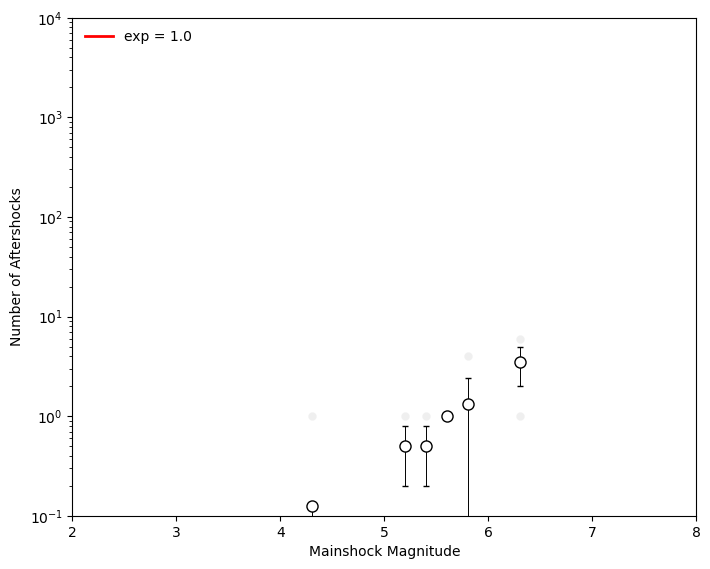

In [14]:
dPar['magRound'] = 1 # binning
#=================plotting==============
dPar['alpha']    =  1.0 # power law exponent
dPar['xmin']     =  2  
dPar['xmax']     =  8
dPar['ymin']     = 0.1  
dPar['ymax']     = 1e4

#=================================2==========================================================================
#                           count ave. no. of aftershocks per MS magnitude
#============================================================================================================
aMag_round= np.around( m_N_as[0], dPar['magRound'])
aMag_bin  = np.array( sorted(np.unique( aMag_round)))
aAveNo_AS = np.ones( len( aMag_bin))*np.nan
aNo_Fam   = np.zeros( len( aMag_bin)) # total number of families within mag bin
aNo_AS20  = np.zeros( len( aMag_bin))
aNo_AS80  = np.zeros( len( aMag_bin))

i = 0
for curr_mag in aMag_bin:
    selMag       = curr_mag == aMag_round
    aAveNo_AS[i] = m_N_as[1][selMag].mean()
    if selMag.sum() > 0:
        aNo_AS20[i]  = np.percentile( m_N_as[1][selMag], 20)
        aNo_AS80[i]  = np.percentile( m_N_as[1][selMag], 80)
    aNo_Fam[i]   = selMag.sum()
    print( curr_mag, 'mean N-AS', round(aAveNo_AS[i],2),  aNo_AS20[i],aNo_AS80[i], 'no. of fam', aNo_Fam[i],end="\r")

    i += 1

#=================================3==========================================================================
#                           plot productivity law
#============================================================================================================
plt.figure(1, figsize=(8,6))
ax = plt.axes([.14,.12,.78,.83])#pPlot.createFigureSquare(1)
ax.semilogy( m_N_as[0],   m_N_as[1],     'o',  ms = 6, mew =0, mfc = '.7', alpha = .2 )
yerr_low = np.maximum(0, aAveNo_AS - aNo_AS20)
yerr_high = np.maximum(0, aNo_AS80 - aAveNo_AS)
#ax.errorbar( aMag_bin,  aAveNo_AS, yerr=[np.zeros(aMag_bin.shape[0]), aNo_AS80-aAveNo_AS],
#             fmt = 'o', ecolor = 'k', elinewidth=.7,capsize=2.5, mec = 'k', ms = 8, mew = 1, mfc = 'w')
#ax.errorbar( aMag_bin,  aAveNo_AS, yerr=[aAveNo_AS-aNo_AS20, aNo_AS80-aAveNo_AS],
#             fmt = 'o', ecolor = 'k', elinewidth=.7,capsize=2.5, mec = 'k', ms = 8, mew = 1, mfc = 'w')
ax.errorbar(aMag_bin, aAveNo_AS, yerr=[yerr_low, yerr_high],
            fmt='o', ecolor='k', elinewidth=.7, capsize=2.5, mec='k', ms=8, mew=1, mfc='w')

#-------------------------exponential - estimate-----------------------------------------------------
mag_fit    = aMag_bin[10] # force fit through this point
f_no_AS_pl = aAveNo_AS[aMag_bin == mag_fit]
preFac     = np.log10( f_no_AS_pl) - dPar['alpha']*mag_fit
a_N_hat    = 10**( dPar['alpha']*aMag_bin + preFac)
ax.semilogy( aMag_bin, a_N_hat, 'w-')
ax.semilogy( aMag_bin, a_N_hat, '-', color = 'r', lw = 2, label = 'exp = %.1f'%( np.round( dPar['alpha'],1)))

#-------------------------------labels, limits etc.-----------------------------------------------
ax.set_xlim( dPar['xmin'], dPar['xmax'])
ax.set_ylim( dPar['ymin'], dPar['ymax'])
ax.set_xlabel( 'Mainshock Magnitude')
ax.set_ylabel( 'Number of Aftershocks')
ax.legend( loc = 'upper left', frameon = False);
